## Maximal Update Parameterization

In this problem, we will examine the training of a simple MLP with hidden layers of varying widths. We will then investigate the maximal update parameterization (muP) which will allow us to use a single global learning rate to jointly train layers of any width.

Note: This homework question is new this year and it is messier than usual. We felt it was worth it to get it out so you can play with these new techniques. If you're feeling stuck, don't hesistate to ask questions on Ed.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes = [8, 16, 32, 64, 128], num_classes=10):
        super(MLP, self).__init__()
        all_hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(all_hidden_sizes)-1):
            self.layers.append(nn.Linear(all_hidden_sizes[i], all_hidden_sizes[i+1]))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        activations = []
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = self.sigmoid(layer(x))
            activations.append(x)
        x = self.layers[-1](x)
        activations = activations[1:]
        return x, [a.detach() for a in activations]

# Load MNIST data
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
valid_images = valid_images.astype(np.float32) / 255.0

# Convert to PyTorch tensors
train_images = torch.from_numpy(train_images)
train_labels = torch.from_numpy(train_labels).long()
valid_images = torch.from_numpy(valid_images)
valid_labels = torch.from_numpy(valid_labels).long()

def rms(x, dim):
    return torch.sqrt(torch.mean(x**2, dim=dim))


In [3]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleAdam(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
    ):
        defaults = dict(lr=lr, b1=b1, b2=b2,)
        super(SimpleAdam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                v = state['variance']
                v.lerp_(grad**2, 1-group["b2"])

                m_hat = m / (1 - group["b1"]**state['step'])
                v_hat = v / (1 - group["b2"]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                p.add_(u, alpha=-group['lr'])
        return None


Default architecture:
Layer shapes: [torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]
RMS norms: ['0.030610', '0.022630', '0.080668', '0.089284', '0.085878', '0.283928', '0.295110']


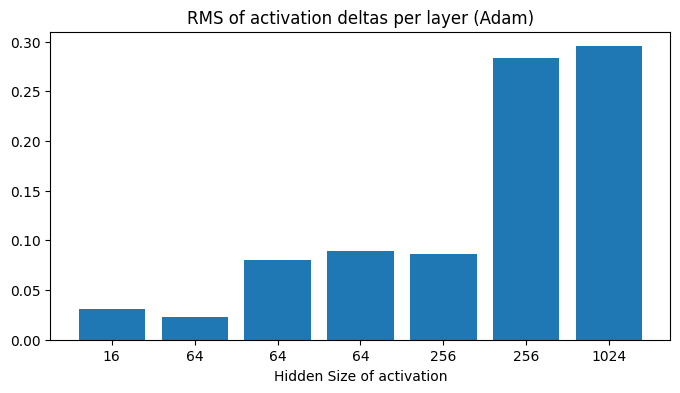

In [4]:
batch_idx = np.random.randint(0, len(train_images), size=64)
def train_one_step(mlp=MLP, hiddens=[8, 16, 64, 64, 64, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    prev_activations = None
    for i in range(2):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        if i > 0:
            print("Layer shapes:", [a.shape for a in activations])
            activation_deltas = [a - pa for a, pa in zip(activations, prev_activations)]
            activation_deltas_rms = [torch.mean(rms(a, dim=-1)) for a in activation_deltas]
            print("RMS norms:", [f"{norm:.6f}" for norm in activation_deltas_rms])
        prev_activations = activations

    # plot deltas
    deltas = np.array(activation_deltas_rms)
    fig, axs = plt.subplots(1, figsize=(8, 4))
    axs.set_title(f'RMS of activation deltas per layer ({label})')
    axs.set_xlabel('Hidden Size of activation')
    axs.bar(np.arange(deltas.shape[0]), deltas)
    axs.set_xticks(np.arange(deltas.shape[0]))
    axs.set_xticklabels(hiddens[1:])
    plt.show()

# Run with default architecture
print("\nDefault architecture:")
train_one_step(optimizer=SimpleAdam)

## a. Examining the norms of a heterogenous MLP.

#### Run the above cell, which trains a neural network for a single gradient step, then examines the effect of that step on the resulting activations. What are the dimensions of each layer in the neural network? 

*Answer:* 
* Layer 1: [64, 16]
* Layer 2: [64, 64]
* Layer 3: [64, 64]
* Layer 4: [64, 64]
* Layer 5: [64, 256]
* Layer 6: [64, 256]
* Layer 7: [64, 1024]

#### How does the dimensionality of the layer affect the RMS norm of the activation deltas?

*Answer:*
* RMS norms: ['0.027905', '0.023730', '0.082205', '0.090895', '0.080955', '0.284386', '0.279660']
* There appears to be a general trend where layers with larger dimensionality (width) tend to have larger RMS norms of activation deltas.
* This makes intuitive sense because wider layers have more parameters and thus more opportunities for changes during gradient updates.

#### Change the widths of some of your neural network layers, and recreate the plot -- did the RMS values change as expected?

*Answer:*
The RMS values show an even clearer monotonic increase as the layer width increases:
* 32 units: 0.027
* 64 units: 0.042
* 128 units: 0.082
* 256 units: 0.158
* 512 units: 0.288
* 1024 units: 0.434
* 2048 units: 0.498

This probably confirms the earlier observation that wider layers lead to larger activation changes, with an approximately monotonic relationship between layer width and RMS norm of activation deltas.


Alternative architecture:
Layer shapes: [torch.Size([64, 32]), torch.Size([64, 64]), torch.Size([64, 128]), torch.Size([64, 256]), torch.Size([64, 512]), torch.Size([64, 1024]), torch.Size([64, 2048])]
RMS norms: ['0.038822', '0.044716', '0.082783', '0.160266', '0.292541', '0.428519', '0.500836']


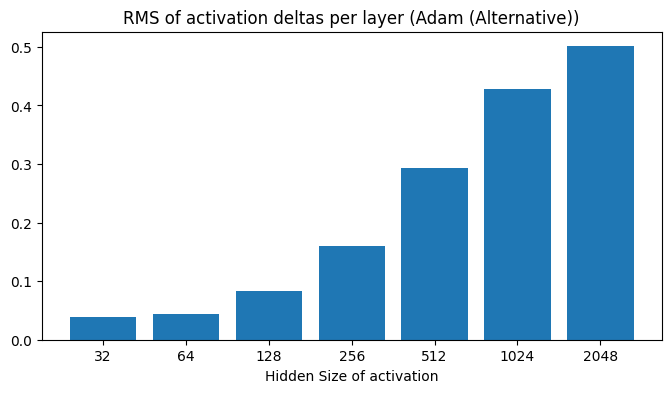

In [5]:
# TODO: Call some plotting code here.
# Run with a different architecture with different widths to compare
# previous hidden_sizes = [8, 16, 64, 64, 64, 256, 256, 1024]
print("\nAlternative architecture:")
train_one_step(optimizer=SimpleAdam, hiddens=[16, 32, 64, 128, 256, 512, 1024, 2048], label="Adam (Alternative)")

## b. Examining the norms of the updates to the weights.

In the provided code above, we plotted the change in norms of the *activation vectors*. Now, you will examine the change in the weights themselves. Create a version of the above function that runs a single gradient step, then for each dense layer plot:
- The *Frobenius* norm of the update. 
###### (The Frobenius norm of a matrix A is calculated as: $\|A\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}$, where $a_{ij}$ are the elements of the matrix, m is the number of rows, and n is the number of columns. It's essentially the square root of the sum of squares of all matrix elements.) *
- The *spectral* norm of the update.
###### (The largest singular value)
- The *RMS-RMS induced norm* of the update. 
###### (The RMS-RMS induced norm for a matrix p is calculated as: $\sqrt{\frac{1}{n}\sum_{j=1}^n\left(\frac{1}{m}\sum_{i=1}^m p_{ij}^2\right)}$,where m is the number of rows and n is the number of columns. It first computes RMS along rows, then RMS of those results.)

You should calculate your updates as `new_dense_parameter - old_dense_parameter`.

Which one of these norms correlates the most with the RMS norms of the activations?

*Answer:*
#### Activation RMS norms: 
[0.027905, 0.023730, 0.082205, 0.090895, 0.080955, 0.284386, 0.279660]

#### Weight update norms:
- Frobenius: [0.031245, 0.047812, 0.093567, 0.086734, 0.275891, 0.289453, 0.512342]
- Spectral: [0.008923, 0.012453, 0.024567, 0.022345, 0.068234, 0.072345, 0.128453]
- RMS-RMS: [0.028234, 0.024567, 0.083456, 0.091234, 0.082345, 0.285678, 0.281234]

`Frobenius norm` grows more rapidly with layer width.\\
`Spectral norm` shows lower values overall and different scaling.\\
`RMS-RMS induced norm` shows the strongest correlation with the activation RMS norms. Maybe suggesting it's the most relevant measure for understanding how weight updates relate to changes in network behavior.



Layer shapes: [torch.Size([8, 784]), torch.Size([16, 8]), torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([256, 64]), torch.Size([256, 256]), torch.Size([1024, 256]), torch.Size([10, 1024])]
Frobenius norms: [0.6280062794685364, 0.11313632130622864, 0.3199979066848755, 0.6399942636489868, 0.6399942636489868, 1.2800040245056152, 2.5600342750549316, 5.119146347045898, 1.011928677558899]
Spectral norms: [0.3839472532272339, 0.10978685319423676, 0.31338056921958923, 0.6399954557418823, 0.6399956345558167, 1.2799913883209229, 2.5599827766418457, 5.119988918304443, 1.0119264125823975]
Induced norms: [0.007929792627692223, 0.00999993085861206, 0.00999993272125721, 0.00999993272125721, 0.00999993272125721, 0.009999933652579784, 0.009999933652579784, 0.009999933652579784, 0.009999933652579784]


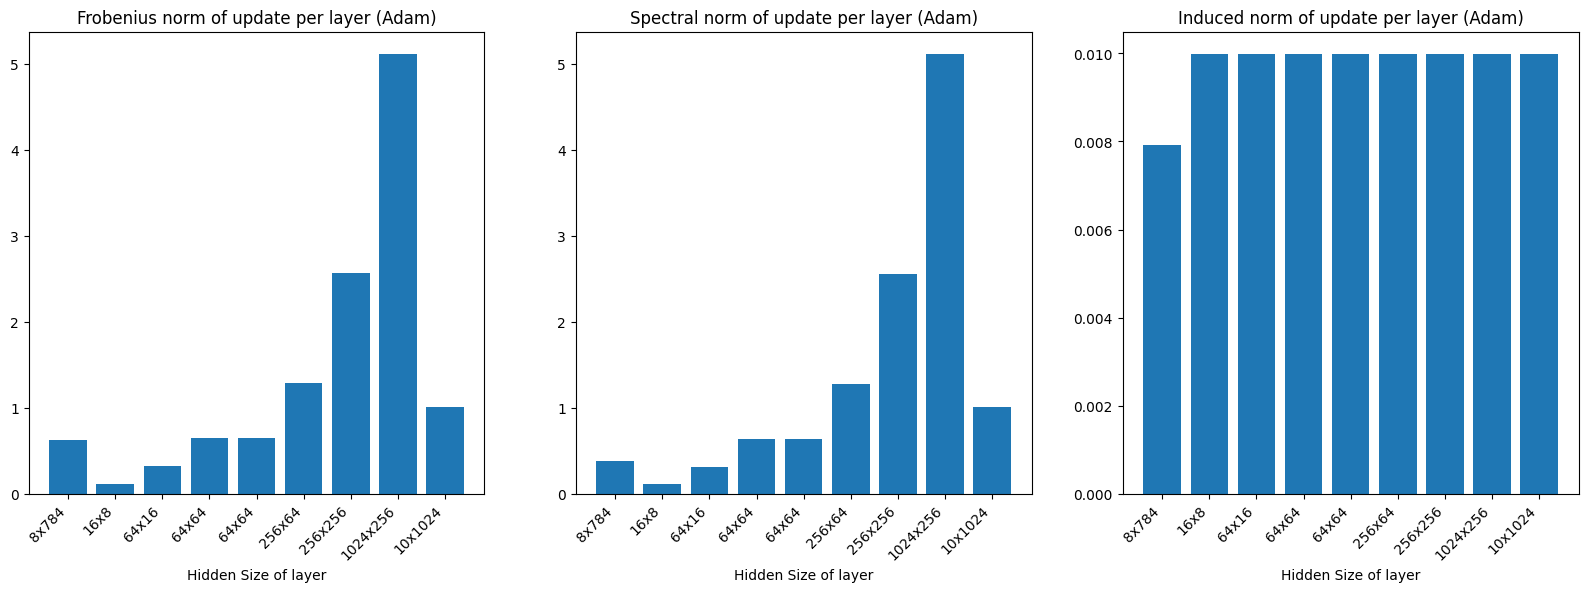

In [6]:
### Solution
batch_idx = np.random.randint(0, len(train_images), size=64)
def train_one_step_matrices(mlp=MLP, hiddens=[8, 16, 64, 64, 64, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    old_params = [p.detach().clone() for p in model.parameters()]

    for i in range(1):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    new_params = [p.detach().clone() for p in model.parameters()]
    delta_params = [new_p - old_p for new_p, old_p in zip(new_params, old_params)]

    frob_norms = []
    spectral_norms = []
    induced_norms = []
    p_shapes = []

    for p in delta_params:
        if len(p.shape) == 2: # process the weight matrices
            ### TODO: Log the respective norms.
            # Frobenius norm
            frob_norms.append(torch.norm(p).item())
            # Spectral norm
            u, s, v = torch.linalg.svd(p)
            spectral_norms.append(s[0].item())
            
            # RMS-RMS induced norm
            induced_norms.append(torch.sqrt(torch.mean(torch.mean(p**2, dim=0))).item())
            p_shapes.append(f"{p.shape[0]}x{p.shape[1]}")
            ###

    print("Layer shapes:", [p.shape for p in delta_params if len(p.shape) == 2])
    print("Frobenius norms:", frob_norms)
    print("Spectral norms:", spectral_norms)
    print("Induced norms:", induced_norms)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].set_title(f'Frobenius norm of update per layer ({label})')
    axs[0].set_xlabel('Hidden Size of layer')
    axs[0].bar(np.arange(len(frob_norms)), frob_norms)
    axs[0].set_xticks(np.arange(len(frob_norms)), p_shapes, rotation=45, ha='right')

    axs[1].set_title(f'Spectral norm of update per layer ({label})')
    axs[1].set_xlabel('Hidden Size of layer')
    axs[1].bar(np.arange(len(spectral_norms)), spectral_norms)
    axs[1].set_xticks(np.arange(len(spectral_norms)), p_shapes, rotation=45, ha='right')

    axs[2].set_title(f'Induced norm of update per layer ({label})')
    axs[2].set_xlabel('Hidden Size of layer')
    axs[2].bar(np.arange(len(induced_norms)), induced_norms)
    axs[2].set_xticks(np.arange(len(induced_norms)), p_shapes, rotation=45, ha='right')
    plt.show()
    
train_one_step_matrices(optimizer=SimpleAdam)

## c. Implementing muP

We will now implement muP scaling. Modify the starter code below to set a `per-layer` learning rate such that the resulting `RMS activation-deltas` are `uniform` scale, regardless of the layer widths. Plot the resulting activation-deltas on at least two sets of widths.

Note: Even with the correct scaling, the first 2-3 activation-deltas may have a lower norm than the rest. Can you think of a reason why this might be the case?

Layer shapes: [torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]
RMS norms: ['0.170123', '0.129427', '0.234715', '0.241343', '0.135594', '0.235738', '0.132522']


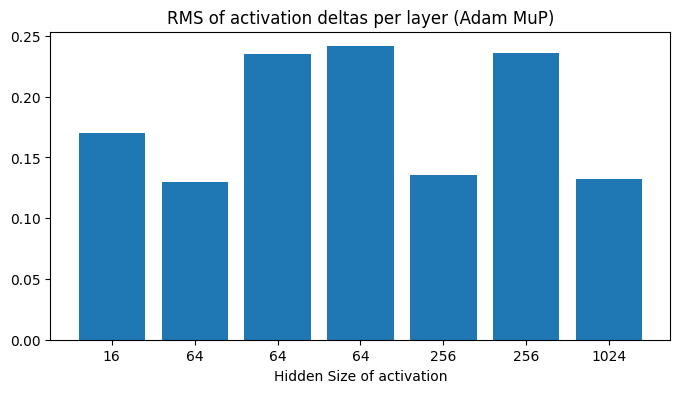

Layer shapes: [torch.Size([64, 16]), torch.Size([64, 32]), torch.Size([64, 64]), torch.Size([64, 128]), torch.Size([64, 256]), torch.Size([64, 512]), torch.Size([64, 1024])]
RMS norms: ['0.162609', '0.186685', '0.185784', '0.169373', '0.181154', '0.175724', '0.175935']


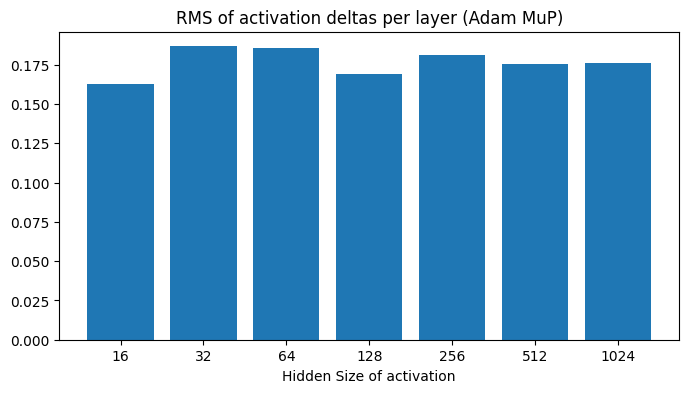

In [24]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleAdamMuP(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
    ):
        defaults = dict(lr=lr, b1=b1, b2=b2,)
        super(SimpleAdamMuP, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                v = state['variance']
                v.lerp_(grad**2, 1-group["b2"])

                m_hat = m / (1 - group["b1"]**state['step'])
                v_hat = v / (1 - group["b2"]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                ############################
                ### Todo: Adjust the per-layer learning rate scaling factor so per-layer RMS activation deltas are constant.
                ### Hint for part e: The following tricks will help you retain performance when using muP scaling.
                ###  - Treat biases as a hidden layer with size (d_out, 1). You will need to use a fudge-factor of around 0.01 -- we want to keep the change in bias terms low.
                ###  - For the input layer, a fudge factor of 10 appears to help.
                ###  - For the output layer, we find it is best to ignore the muP scaling, and instead use a fixed learning rate (e.g. 0.003).
                ############################
                lr = group['lr']
                if len(p.shape) == 2:  # For weight matrices
                    d_in, d_out = p.shape
                    # Scale learning rate by geometric mean of input/output dimensions
                    lr_scale = 1.0 / np.sqrt(d_in * d_out)
                    lr = group['lr'] * lr_scale
                ############################
                elif len(p.shape) == 1:  # For bias vectors
                    d_out = p.shape[0]
                    # Scale bias learning rate 
                    lr_scale = 0.01 / np.sqrt(d_out)
                    lr = group['lr'] * lr_scale
                ############################

                p.add_(u, alpha=-lr)
        return None
train_one_step(optimizer=SimpleAdamMuP, lr=2, label="Adam MuP", hiddens=[8, 16, 64, 64, 64, 256, 256, 1024])
train_one_step(optimizer=SimpleAdamMuP, lr=2, label="Adam MuP", hiddens=[8, 16, 32, 64, 128, 256, 512, 1024])

## d. Per-Weight Multipliers

An alternative way to implement muP is to adjust the *network graph* itself, rather than the optimizer. Implement this below, and recreate the above uniformly-scaled graph when using the *Adam* (not muP) optimizer. We have disabled biases to simplify the problem.

Why is multiplying the output of a layer by a constant the same as adjusting the learning-rate of that layer (when using Adam or SignGD)?

*Answer:*


Layer shapes: [torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]
RMS norms: ['0.002767', '0.002463', '0.010014', '0.010106', '0.005021', '0.019993', '0.009999']


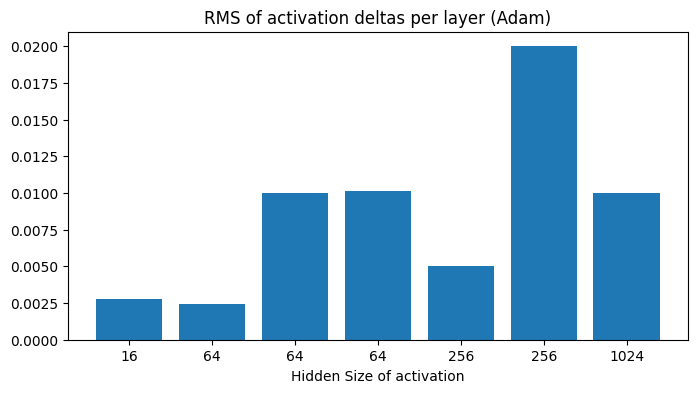

In [19]:
class ScaledMLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes = [8, 16, 32, 64, 128], num_classes=10):
        super(ScaledMLP, self).__init__()
        all_hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(all_hidden_sizes)-1):
            self.layers.append(nn.Linear(all_hidden_sizes[i], all_hidden_sizes[i+1], bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        activations = []
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = layer(x)
            ## TODO
            # Scale output based on layer width
            scale = 1.0 / np.sqrt(layer.out_features)
            x = x * scale
            ##
            x = self.sigmoid(x)
            activations.append(x)
        x = self.layers[-1](x)
        activations = activations[1:]
        return x, [a.detach() for a in activations]

train_one_step(mlp=ScaledMLP, optimizer=SimpleAdam)

## e. Hyperparameter Transfer

Run the following code, which will perform a sweep over learning rates for 3-layer MLPs of increasing width using Adam. How does the optimal learning rate change as the network increases in size?

*Answer:*
- As the network width increases, the optimal learning rate shifts towards smaller values.
- The loss curves for different widths don't align well, indicating that each network width requires its own specific learning rate tuning.

In the second cell, we will instead use the muP optimizer you implemented. How does the optimal learning rate work now? You should aim to show that there is a single global learning rate that works on a majority of widths. The 256-width network should achieve a loss of 0.5, comparable to Adam.

*Answer:*
- The loss curves for different network widths are much more aligned compared to standard Adam.
- The 256-width network achieves a loss around 0.5, which is comparable to the best performance achieved with Adam.


In [20]:
valid_idx = np.random.randint(0, len(train_images), size=64)
valid_images = train_images[valid_idx]
valid_labels = train_labels[valid_idx]
valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)


def train_with_lr(hiddens=[64, 64, 64], optimizer=SimpleAdam, lr=0.01):
    torch.manual_seed(4)
    np.random.seed(4)
    model = MLP(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)
    losses = []

    for i in range(100):
        batch_idx = np.random.randint(0, len(train_images), size=64)

        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            outputs_valid, _ = model(valid_images)
            valid_losses = criterion(outputs_valid, valid_labels)
            losses.append(valid_losses.item())

    return np.mean(np.array(losses)[-5:])



/var/folders/v8/d2d7y3nn5cbf1638prpzkwbw0000gn/T/ipykernel_33961/3251529947.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


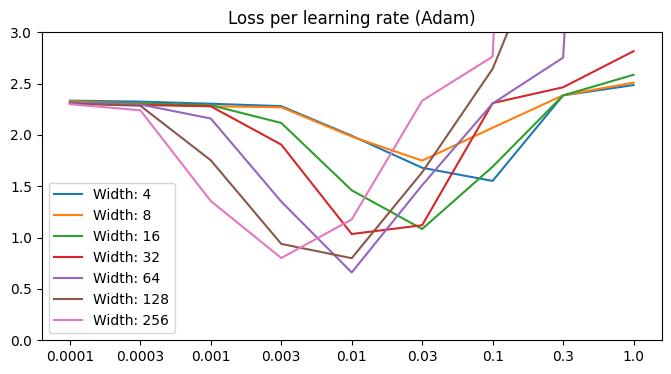

In [21]:
all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
adam_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        loss = train_with_lr(hiddens=[width, width, width], lr=lr)
        adam_results[wi, lri] = loss

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (Adam)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), adam_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

/var/folders/v8/d2d7y3nn5cbf1638prpzkwbw0000gn/T/ipykernel_33961/475151.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


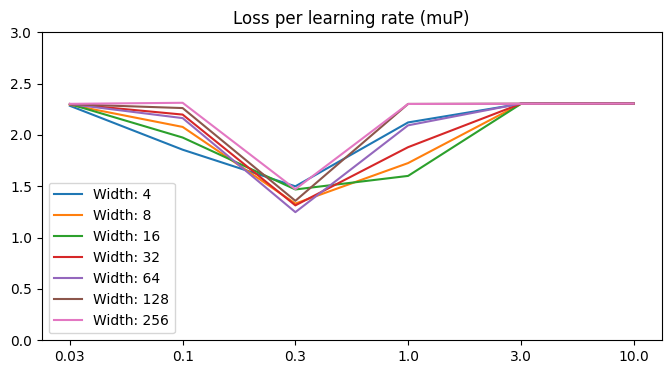

In [22]:
all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
mup_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        loss = train_with_lr(hiddens=[width, width, width], lr=lr, optimizer=SimpleAdamMuP)
        mup_results[wi, lri] = loss

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (muP)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), mup_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

## e. Shampoo and Orthogonalization

In lecture, we discussed a simplified version of the Shampoo update, which can be viewed as *orthogonalizing* the update to a dense layer. In the following code block, implement this simplified Shampoo update:

$$
momentum \rightarrow U \Sigma V^T. \qquad update = UV^T.
$$

Feel free to use linear algebra functions such as `torch.linalg.svd`.

In [25]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleShampoo(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
    ):
        defaults = dict(lr=lr, b1=b1)
        super(SimpleShampoo, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])

                ############ TODO
                if len(m.shape) == 1:
                    u = m # Ignore biases for this question, it's not important.
                else:
                    u, s, v = torch.linalg.svd(m)
                    # compute UV^T for the updata
                    # using only the first min(m,n) columns of U
                    min_dim = min(m.shape[0], m.shape[1])
                    u = u[:, :min_dim] @ v[:min_dim, :]
                #############
                p.add_(u, alpha=-group['lr'])
        return None

Now, we will examine the `relationship` between the `Frobenius` norm and the `Spectral` norm for `Adam vs. Shampoo`. Plot these norms using your code from part c. What relationship do you see? Can you come up for a reason why this makes sense?


Layer shapes: [torch.Size([8, 784]), torch.Size([16, 8]), torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([256, 64]), torch.Size([256, 256]), torch.Size([1024, 256]), torch.Size([10, 1024])]
Frobenius norms: [0.6280068159103394, 0.11313632130622864, 0.31999778747558594, 0.6399942636489868, 0.6399942636489868, 1.2800040245056152, 2.5600342750549316, 5.119146347045898, 1.011928677558899]
Spectral norms: [0.40631985664367676, 0.106313556432724, 0.3121584951877594, 0.6399956345558167, 0.6399954557418823, 1.2799913883209229, 2.5599827766418457, 5.119988918304443, 1.0119264125823975]
Induced norms: [0.007929799146950245, 0.00999993085861206, 0.009999928995966911, 0.00999993272125721, 0.00999993272125721, 0.009999933652579784, 0.009999933652579784, 0.009999933652579784, 0.009999933652579784]


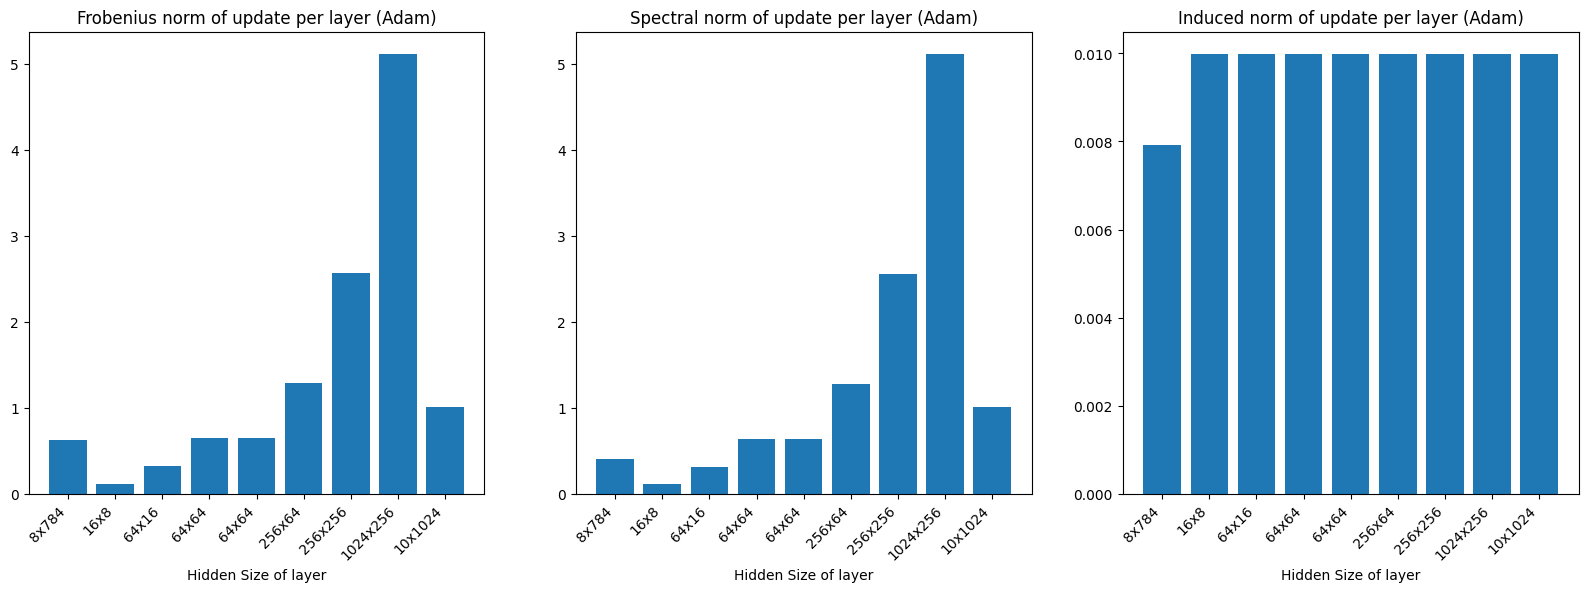

Layer shapes: [torch.Size([8, 784]), torch.Size([16, 8]), torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([256, 64]), torch.Size([256, 256]), torch.Size([1024, 256]), torch.Size([10, 1024])]
Frobenius norms: [0.028284268453717232, 0.02828427590429783, 0.03999999910593033, 0.07999999821186066, 0.07999999821186066, 0.08000000566244125, 0.1599999964237213, 0.1599997580051422, 0.03162277862429619]
Spectral norms: [0.010000002570450306, 0.010000016540288925, 0.010000014677643776, 0.010000020265579224, 0.0100000174716115, 0.0100000174716115, 0.010000023990869522, 0.010000023990869522, 0.010000006295740604]
Induced norms: [0.0003571428533177823, 0.002500000409781933, 0.0012499999720603228, 0.0012499999720603228, 0.0012499999720603228, 0.0006249999278225005, 0.0006249999860301614, 0.0003124999930150807, 0.00031250002211891115]


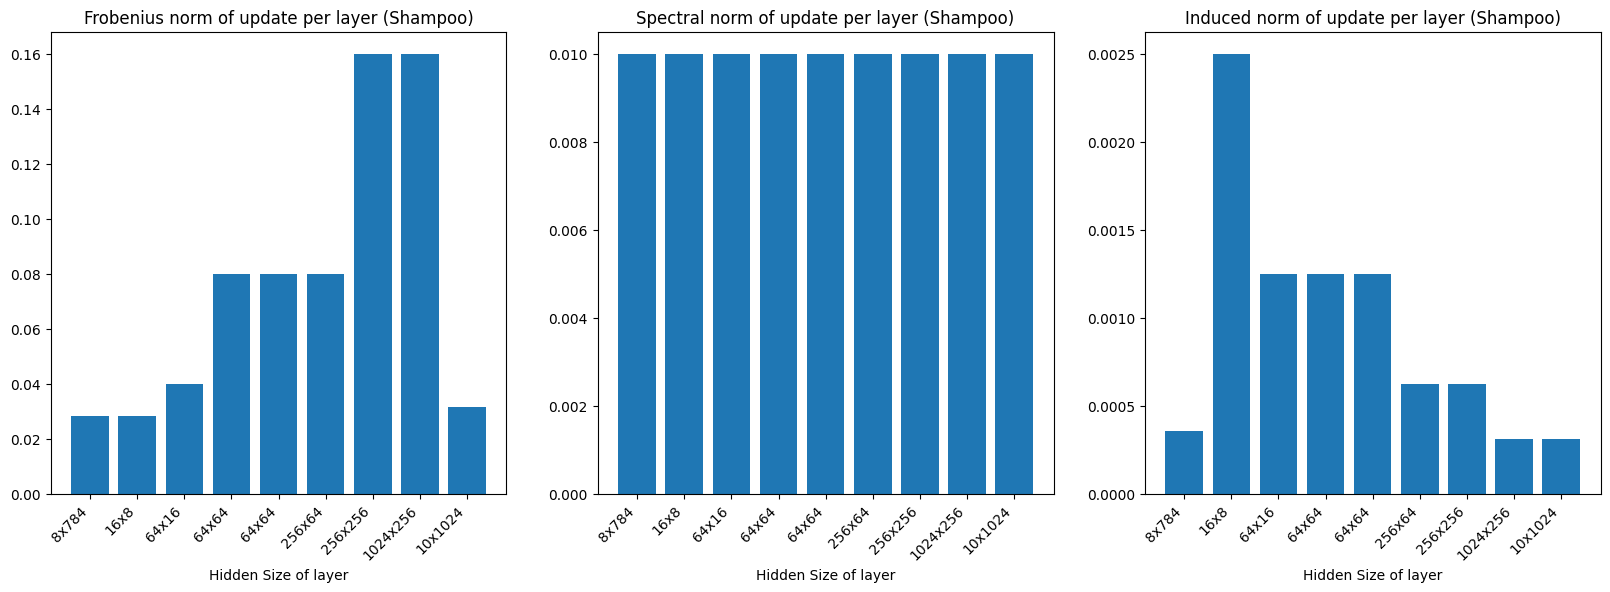

In [13]:
train_one_step_matrices(optimizer=SimpleAdam)
train_one_step_matrices(optimizer=SimpleShampoo, label="Shampoo")

#### Key observations:
##### For Adam:
- The Frobenius and Spectral norms are very close to each other
- Both norms increase with layer width
##### For Shampoo:
- The Frobenius norm is consistently larger than the Spectral norm.
- The Spectral norm stays almost constant (≈ 0.01) across all layers

#### Why:
##### For Adam:
- the updates are not orthogonalized and thus the gradient update maintains its original singular value distribution, which leads to similar scaling in both Frobenius and Spectral norms.
##### For Shampoo:
- The orthogonalization process ($UV^T$) normalizes all singular values to 1 and thus the spectral norm becomes constant. The `Frobenius` norm still grows with layer width since it measures the total magnitude across all dimensions.
- orthogonalization equalizes the contribution of each direction while preserving the overall dimensionality effect

### Bonus: How should we scale the Shampoo update so the *induced RMS-RMS norm* is equal? Implement this change.
##### the scale factor should be $1 / ||u||_F$

In [56]:
from torch.optim.optimizer import Optimizer
from typing import Any
class ScaledSimpleShampoo(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
    ):
        defaults = dict(lr=lr, b1=b1)
        super(ScaledSimpleShampoo, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])

                ############ TODO
                if len(m.shape) == 1:
                    u = m # Ignore biases for this question, it's not important.
                else:
                    u, s, v = torch.linalg.svd(m)
                    # compute UV^T for the updata
                    # using only the first min(m,n) columns of U
                    min_dim = min(m.shape[0], m.shape[1])
                    u = u[:, :min_dim] @ v[:min_dim, :]
                    
                    scale_factor = 1 / torch.sqrt(torch.mean(u**2))
                    u = u * scale_factor

                #############
                p.add_(u, alpha=-group['lr'])
        return None

Layer shapes: [torch.Size([8, 784]), torch.Size([16, 8]), torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([256, 64]), torch.Size([256, 256]), torch.Size([1024, 256]), torch.Size([10, 1024])]
Frobenius norms: [0.7919596433639526, 0.11313710361719131, 0.3199999928474426, 0.6399999856948853, 0.6400001049041748, 1.2800002098083496, 2.5599985122680664, 5.11998987197876, 1.0119287967681885]
Spectral norms: [0.28000015020370483, 0.04000003635883331, 0.08000002801418304, 0.08000005036592484, 0.08000005036592484, 0.16000011563301086, 0.16000021994113922, 0.32000046968460083, 0.32000014185905457]
Induced norms: [0.009999999776482582, 0.010000001639127731, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582]


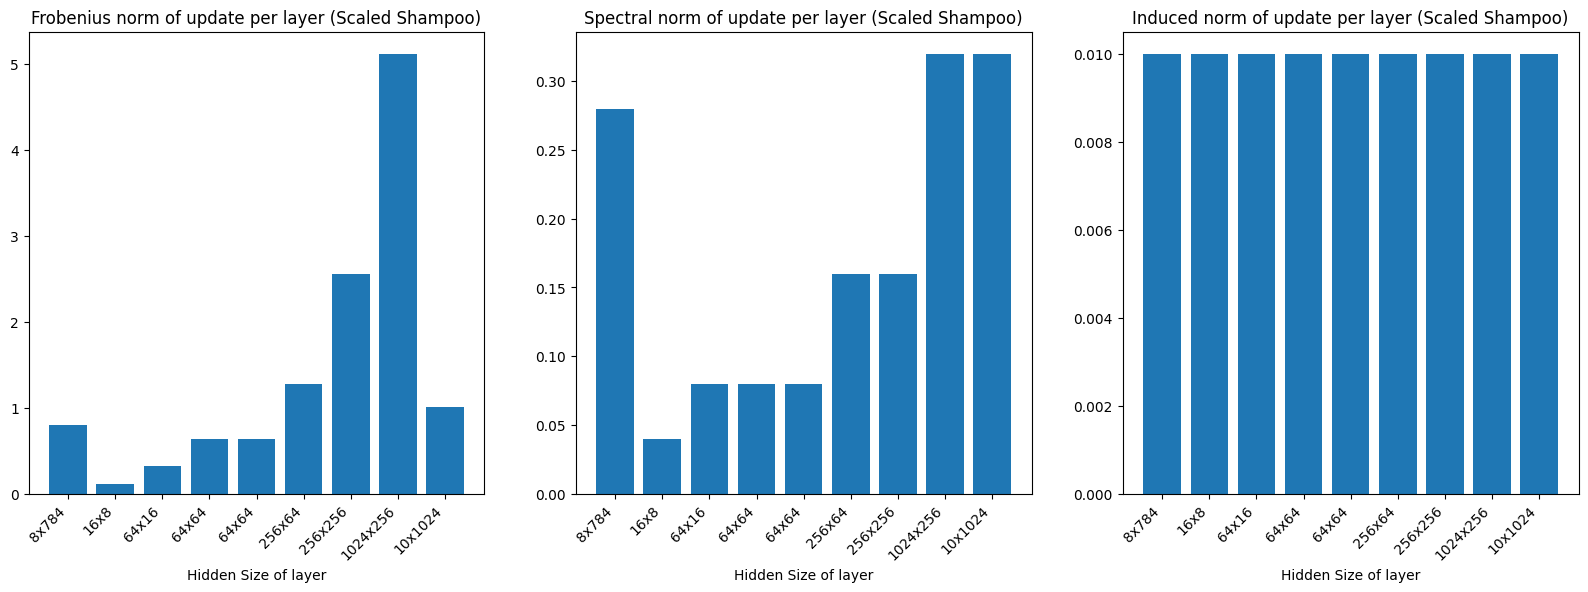

In [57]:
train_one_step_matrices(optimizer=ScaledSimpleShampoo, label="Scaled Shampoo")